# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 0
key = jax.random.PRNGKey(seed)
sample_key, shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 5)

gamma = 0.95

# Sample collection
n_states_x = 10
max_state_x = 0.95
n_states_v = 10
max_state_v = 2.95
n_actions = 2
n_uniform_samples = 200
n_samples = n_states_x * n_states_v * n_actions + n_uniform_samples

# # Weights collection
n_weights = 100

# # Trainings
layers_dimension = (10,)
max_bellman_iterations = 5
batch_size_samples = n_samples

# ## Linear PBO
training_steps = 100
fitting_steps = 5
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.0005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# ## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.1, "last": 0.005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# # Visualisation of errors and performances
n_states_x_visu = 10
n_states_v_visu = 10
horizon = 70

## Define environment

In [2]:
from pbo.environment.car_on_hill import CarOnHillEnv

max_pos = 1.0
max_velocity = 3.0
margin = 0.01
max_pos_margin = max_pos - margin
max_velocity_margin = max_velocity - margin

states_x_visu = jnp.linspace(-max_pos_margin, max_pos_margin, n_states_x_visu)
boxes_x_size = (2 * max_pos_margin) / (n_states_x_visu - 1)
states_x_boxes = (np.linspace(-max_pos_margin, max_pos_margin + boxes_x_size, n_states_x_visu + 1) - boxes_x_size / 2)
states_v_visu = jnp.linspace(-max_velocity_margin, max_velocity_margin, n_states_v_visu)
boxes_v_size = (2 * max_velocity_margin) / (n_states_v_visu - 1)
states_v_boxes = (np.linspace(-max_velocity_margin, max_velocity_margin + boxes_v_size, n_states_v_visu + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

for state_x in jnp.linspace(-max_state_x, max_state_x, n_states_x):
    for state_v in jnp.linspace(-max_state_v, max_state_v, n_states_v):
        state = jnp.array([state_x, state_v])
        
        for action in jnp.arange(n_actions):
            env.reset(state)
            next_state, reward, absorbing, _ = env.step(jnp.array([action]))

            replay_buffer.add(state, jnp.array([action]), reward, next_state, absorbing)

env.reset()
for idx_sample in range(n_uniform_samples):
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)

    replay_buffer.add(env.state, action, reward, next_state, absorbing)

    if absorbing:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.uniform(key, (2,), minval=jnp.array([-max_pos_margin, -max_velocity_margin]), maxval=jnp.array([max_pos_margin, max_velocity_margin])))

replay_buffer.cast_to_jax_array()

### Visualize samples

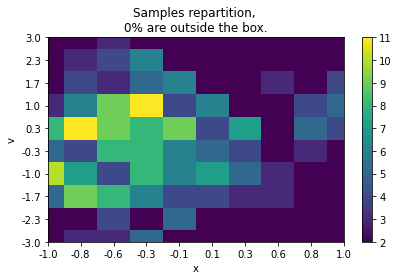

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes)
samples_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Train Q with Fitted-Q with enough power to make it working

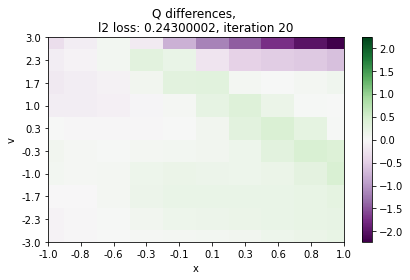

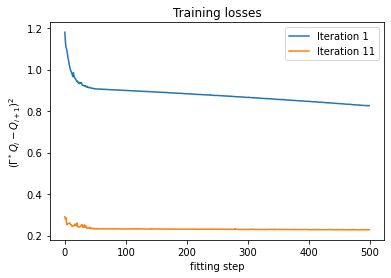

In [5]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


max_bellman_iterations_best = 20
fitting_steps_q_best = 500
n_samples_best = n_samples

data_loader_samples = SampleDataLoader(replay_buffer, n_samples_best, shuffle_key)
q_best = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate={"first": 0.01, "last": 0.0005, "duration": fitting_steps_q_best},
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations_best, fitting_steps_q_best)) * np.nan

for bellman_iteration in range(max_bellman_iterations_best):
    params_target = q_best.params
    q_best.reset_optimizer()

    for step in range(fitting_steps_q_best):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q_best.params, q_best.optimizer_state, l2_loss = q_best.learn_on_batch(q_best.params, params_target, q_best.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q_best, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")


for bellman_iteration in range(0, max_bellman_iterations_best, 10):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [6]:
state = jnp.array([-0.6, 2.9])
env.reset(state)

env.step(jnp.array([1]))

(DeviceArray([-0.29116774,  2.9982426 ], dtype=float32),
 DeviceArray([0.], dtype=float32),
 DeviceArray([False], dtype=bool),
 {})

In [7]:
print(q_best(q_best.params, state, jnp.array([0])))
print(q_best(q_best.params, state, jnp.array([1])))

[0.09158754]
[0.17270827]


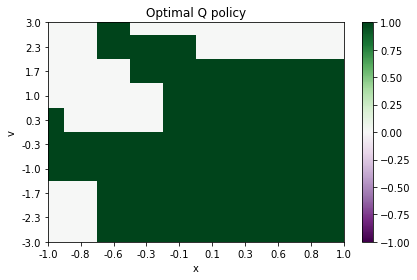

In [8]:
best_diff_q = env.diff_q_mesh(q_best, states_x_visu, states_v_visu)

q_visu_mesh.set_values((best_diff_q > 0).astype(float))
q_visu_mesh.show("Optimal Q policy", xlabel="x", ylabel="v")

In [9]:
env.simulate(q_best, horizon, jnp.array([0.1, 0]))

[0.1 0. ]
[0.03868401]
[0.11972308]

[ 0.08627377 -0.274483  ]
[-0.01654816]
[0.07495749]

[ 0.04508943 -0.54966766]
[-0.06883383]
[0.04870522]

[-0.0242627  -0.85262537]
[-0.11995018]
[0.03969288]

[-0.1273641 -1.2097645]
[-0.1626774]
[0.03748095]

[-0.26478705 -1.51845   ]
[-0.14621341]
[0.04018271]

[-0.42251718 -1.5692831 ]
[-0.07690537]
[0.04822659]

[-0.5635786 -1.1870116]
[0.01196086]
[0.08121538]

[-0.6520557 -0.5657202]
[0.11335874]
[0.15432727]

[-0.67556614  0.09636234]
[0.32631123]
[0.32517493]

[-0.6686346   0.04007275]
[0.31571233]
[0.31938708]

[-0.6319083   0.69197863]
[0.5319344]
[0.45671475]

[-0.57062274  0.5101108 ]
[0.5258814]
[0.47403467]

[-0.5337424   0.21370886]
[0.48864186]
[0.46540368]

[-0.52941394 -0.1286773 ]
[0.42432988]
[0.43150175]

[-0.5194253  0.325478 ]
[0.511232]
[0.47745192]

[-0.5057069  -0.05579444]
[0.4550656]
[0.45534003]

[-0.49088177  0.34739318]
[0.5175637]
[0.4817778]

[-0.47780982 -0.09000473]
[0.46182454]
[0.4656042]

[-0.4690236   0.2626

DeviceArray([False], dtype=bool)

## Train Q with Fitted-Q

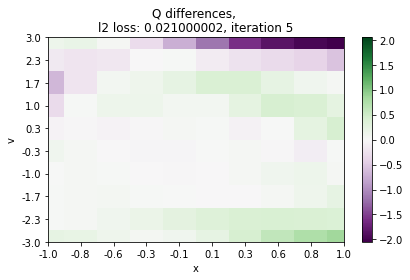

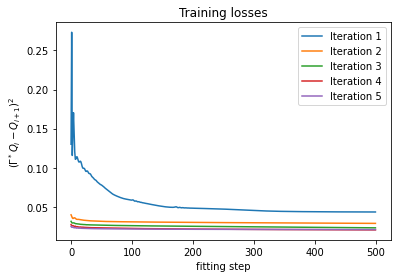

In [10]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in range(max_bellman_iterations):
    params_target = q.params

    for step in range(fitting_steps_q):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

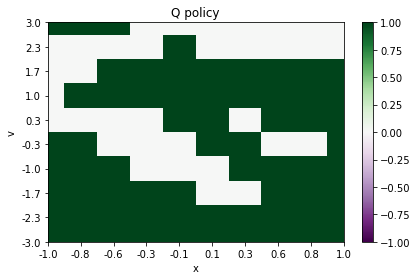

In [11]:
diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show("Q policy", xlabel="x", ylabel="v")

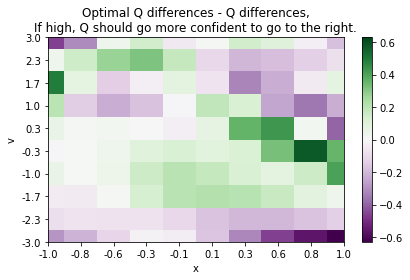

In [13]:
q_visu_mesh.set_values(best_diff_q - diff_q)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.", xlabel="x", ylabel="v")

In [14]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.13134056]
[0.06783736]

[-0.5196691 -0.3866922]
[0.06163621]
[0.05529845]

[-0.57458174 -0.69058496]
[-0.00122386]
[0.04731679]

[-0.6150591  -0.11151298]
[0.10243201]
[0.06720608]

[-0.63391644 -0.25889763]
[0.05855387]
[0.05446887]

[-0.66504884 -0.35312155]
[0.01813513]
[0.0415352]

[-0.66729647  0.30823508]
[0.18594533]
[0.13950813]

[-0.6403723  0.2211848]
[0.16817975]
[0.11356676]

[-0.6245651  0.0893992]
[0.1446119]
[0.08959711]

[-0.62311697 -0.06095137]
[0.11277652]
[0.07181275]

[-0.6363288  -0.19861932]
[0.07410437]
[0.05867696]

[-0.66147864 -0.29581106]
[0.03621817]
[0.04664379]

[-0.65829575  0.3593349 ]
[0.19270426]
[0.14964926]

[-0.6272017   0.25175586]
[0.17146933]
[0.11617452]

[-0.6097064   0.09184372]
[0.14552999]
[0.08816624]

[-0.6094886 -0.0875672]
[0.10917872]
[0.06928807]

[-0.62659454 -0.24838366]
[0.06406462]
[0.05607903]

[-0.6574255 -0.3575211]
[0.02095795]
[0.04333287]

[-0.660475   0.2966658]
[0.18297893]
[0.13473809]

[-0.635337    0.1975

DeviceArray([False], dtype=bool)

## Collect weights

In [15]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
validation_initial_weight = q.to_weights(q.params) * 0
weights_buffer.add(validation_initial_weight)

# Add randow weights
q_pbo = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_pbo.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

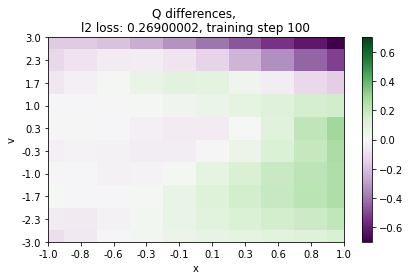

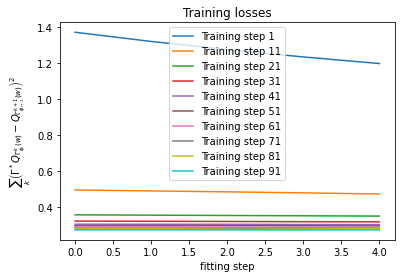

In [16]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q_pbo, max_bellman_iterations, True, pbo_network_key, learning_rate)  # add_infinity == True
importance_iteration = jnp.ones(max_bellman_iterations + 1)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params
    # pbo.reset_optimizer()

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss

    q_pbo.params = q.to_params(pbo.fixed_point(pbo.params))
    diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q_pbo)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps, 10):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

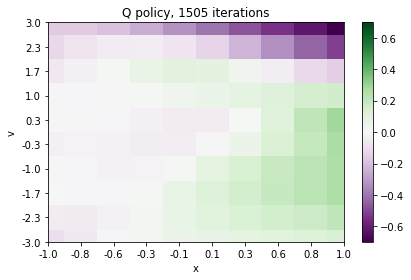

In [17]:
test_bellman_iterations = max_bellman_iterations + 1500

q_weight = validation_initial_weight
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q_pbo.params = q_pbo.to_params(q_weight)

q_pbo.params = q_pbo.to_params(pbo.fixed_point(pbo.params))

diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(diff_q_pbo)
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

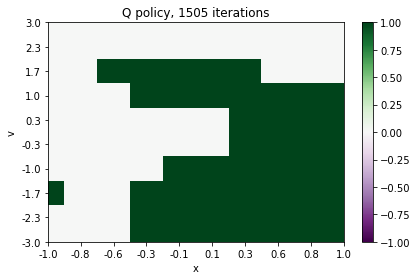

In [18]:
q_visu_mesh.set_values((diff_q_pbo > 0).astype(float))
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

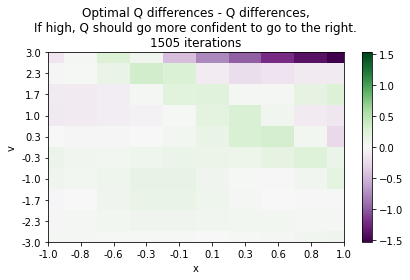

In [19]:
q_visu_mesh.set_values(best_diff_q - diff_q_pbo)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.\n{test_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [20]:
q_weight = validation_initial_weight
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q_pbo.params = q_pbo.to_params(q_weight)

q_pbo.params = q_pbo.to_params(pbo.fixed_point(pbo.params))


env.simulate(q_pbo, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[-0.8354114]
[-0.85702693]

[-0.5196691 -0.3866922]
[-0.82387817]
[-0.8517513]

[-0.57458174 -0.69058496]
[-0.83047533]
[-0.8575791]

[-0.6524237  -0.83584255]
[-0.8629248]
[-0.8852359]

[-0.73584473 -0.8066418 ]
[-0.9018276]
[-0.9215509]

[-0.80970716 -0.6561602 ]
[-0.93759584]
[-0.9594629]

[-0.86512876 -0.44623235]
[-0.9639958]
[-0.98896426]

[-0.8982154  -0.21346611]
[-0.9772396]
[-1.0006719]

[-0.9076059  0.0260565]
[-0.97781587]
[-0.9945248]

[-0.8930263  0.2648832]
[-0.9663325]
[-0.97537977]

[-0.8549221   0.49457222]
[-0.9417553]
[-0.94759905]

[-0.7950392  0.6956501]
[-0.90510887]
[-0.91356325]

[-0.7181284  0.8256852]
[-0.8646014]
[-0.87606186]

[-0.6344481  0.819949 ]
[-0.8340861]
[-0.8453475]

[-0.56017905  0.63601786]
[-0.82596385]
[-0.8384186]

[-0.5121399   0.30687565]
[-0.834871]
[-0.85141957]

[-0.50094044 -0.08663984]
[-0.8333522]
[-0.856601]

[-0.5288892  -0.46262816]
[-0.8226646]
[-0.85105085]

[-0.59008545 -0.73743284]
[-0.83598554]
[-0.8621334]

[-0.67

DeviceArray([False], dtype=bool)